In [1]:
import mdshare
#from torch.utils import data
import nglview as ng
import glob
import sys, os

import numpy as np
import mdshare 
import mdtraj as md
import glob
#import pyemma as py
import matplotlib.pyplot as plt

import pickle as pkl

In [2]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data_mdshare')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data_mdshare')

trj = md.load(files, top=pdb)
trjs = [md.load(file, top=pdb) for file in files]

# load both in trajs
#heavy_idxs = trj.top.select_atom_indices('heavy')
heavy_idxs = trj.top.select('backbone')

heavy_trj = trj.atom_slice(heavy_idxs)
heavy_trj = heavy_trj.superpose(heavy_trj)
heavy_trjs = [t.atom_slice(heavy_idxs) for t in trjs]


(25, 5001, 190)


calculate covariances:   0%|          | 0/20 [00:00<?, ?it/s]

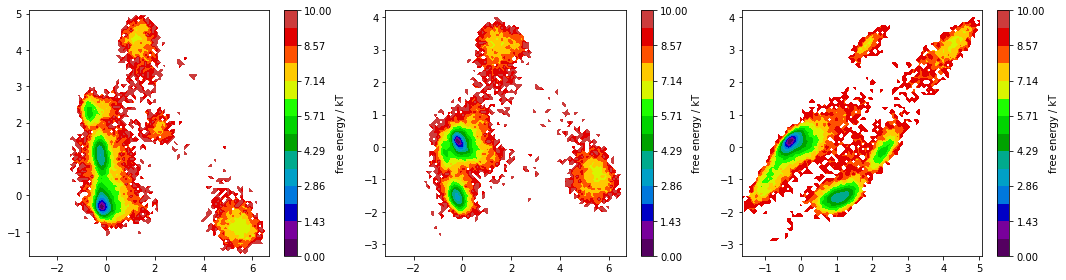

In [3]:
# train tica using pyemma
import pyemma as py
from pyemma.coordinates import tica
from scipy.spatial.distance import pdist

# train tica
n_trajs_train = 20
n_frames = 5001
pdists = [np.concatenate([pdist(xyz)[None] for xyz in trj.xyz]) for trj in heavy_trjs]

print(np.shape(pdists))

TICA = tica(pdists[:n_trajs_train], lag=5, dim=4)

projected_data = np.array(TICA.transform(pdists))
projected_data_cat = projected_data.reshape(-1, projected_data.shape[-1])
projected_data_cat.shape

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()
py.plots.plot_free_energy(projected_data_cat[:,0], projected_data_cat[:,1], levels=np.linspace(0, 10, 15), ax=ax[0])
py.plots.plot_free_energy(projected_data_cat[:,0], projected_data_cat[:,2], levels=np.linspace(0, 10, 15), ax=ax[1])
py.plots.plot_free_energy(projected_data_cat[:,1], projected_data_cat[:,2], levels=np.linspace(0, 10, 15), ax=ax[2])
plt.tight_layout()

pkl.dump(TICA, open('./traj_AIB9/tica_pep_backbone.pkl', 'wb'))

In [6]:
cond_type = 'backbone'

if cond_type == 'backbone':

    # for saving heavy atoms only
    n_atoms = heavy_trj[0].xyz.shape[1]
    x = np.concatenate([t.xyz.reshape(-1, n_atoms*3) for t in heavy_trjs])
    
elif cond_type == 'heavy':

    # for saving all atoms conditioned on heavy
    n_atoms = trjs[0].xyz.shape[1]
    x = np.concatenate([t.xyz.reshape(-1, n_atoms*3) for t in trjs])

n_cond = 4
s = np.concatenate(projected_data)

print(n_atoms, x.shape, s.shape)

20 (125025, 60) (125025, 4)


In [7]:
# condition on first two srvs
n_train = n_trajs_train * n_frames
print(n_train)

training = np.concatenate([s[:n_train, :], x[:n_train, :]], axis=-1)
testing = np.concatenate([s[n_train:, :], x[n_train:, :]], axis=-1)

train_conditions =  training[:, :n_cond]
test_conditions =  testing[:, :n_cond]

if cond_type == 'backbone':

    np.save('./traj_AIB9/train_pep_traj.npy', training)
    np.save('./traj_AIB9/test_pep_traj.npy', testing)
    np.save('./traj_AIB9/train_pep_cond_traj.npy', train_conditions)
    np.save('./traj_AIB9/test_pep_cond_traj.npy', test_conditions)
    pkl.dump(TICA, open('./traj_AIB9/tica_pep_backbone.pkl', 'wb'))

elif cond_type == 'heavy':

    np.save('./traj_AIB9/train_pep_AA-heavy_traj.npy', training)
    np.save('./traj_AIB9/test_pep_AA-heavy_traj.npy', testing)
    np.save('./traj_AIB9/train_pep_AA-heavy_cond_traj.npy', train_conditions)
    np.save('./traj_AIB9/test_pep_AA-heavy_cond_traj.npy', test_conditions)
    pkl.dump(TICA, open('./traj_AIB9/tica_pep_AA-heavy.pkl', 'wb'))

print(training.shape, testing.shape, test_conditions.shape)


100020
(100020, 64) (25005, 64) (25005, 4)


In [8]:
# test does 3 channels (xyz work better under new framework?)
# add conditioning at ends instead of on top?

In [37]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn 
from torch.utils import data

sys.path.append('./denoising_diffusion_pytorch')

from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer, Dataset_traj, cycle, num_to_groups

from denoising_diffusion_pytorch_1d_MJ import Unet1D, GaussianDiffusion1D

from denoising_diffusion_pytorch_MJ import Unet, GaussianDiffusion

from Unets_MJ import Unet_noattn, simple_MLP, simple_Conv, Unet_xyz

from Unets_pos_cond import Unet_cond

device = torch.device("cuda")  #torch.device("cuda")

# define which U-net architecture to use
#model = Unet(dim = 32, dim_mults = (1, 2, 2, 4), groups = 8).to(device)
#model =  Unet_xyz(dim = 32, n_conds=n_cond, dim_mults = (1, 2, 2, 4), groups = 8).to(device)
#model =  Unet_cond(dim = 32, n_conds=n_cond, dim_mults = (1, 2, 2, 4), groups = 8).to(device)

#model = Unet(dim = 32, dim_mults = (1, 2, 2, 4), groups = 8).to(device)
model = Unet1D(dim = 32, dim_mults = (1, 2, 2, 4), channels=1,              # dim_mults =  (1, 2, 4, 8 )
              self_condition=True, random_fourier_features=True, 
            learned_sinusoidal_cond=True, learned_sinusoidal_dim=16) 

model = nn.DataParallel(model)
model.to(device)

# define diffusion model
op_num = n_atoms*3 + n_cond      # override this to the mean the total number of features
konw_op_num = n_cond             # passing in 0 means no masking


diffusion = GaussianDiffusion(
    model,                          # U-net model
    timesteps = 1000,               # number of diffusion steps
    unmask_number = konw_op_num,    # konw_op_num,  # the dimension of x2 in P(x1|x2)
    loss_type = 'l1',                # L1 or L2
    beta_schedule = 'cosine'
).to(device)

'''

# need to add the masking component
diffusion = GaussianDiffusion1D(
    model,                          # U-net model
    seq_length = op_num,
    timesteps = 1000,               # number of diffusion steps
    # unmask_number = konw_op_num,    # konw_op_num,  # the dimension of x2 in P(x1|x2)
    objective = 'pred_noise',
    beta_schedule = 'cosine',
    loss_type = 'l2'                # L1 or L2
).to(device)

'''

#set training parameters
trainer = Trainer(
    diffusion,                                   # diffusion model
    folder = 'traj_AIB9',                        # folder of trajectories
    system = 'train_pep_AA',         #'AIB9_REMD_T_full_100000ps_2.0ps',  # name of the trajectory, the file {system}_traj.npy will be used as the training set
    train_batch_size = 128,                      # training batch size
    train_lr = 1e-5,                             # learning rate
    train_num_steps = 2_000, #2000000,                   # total training steps
    gradient_accumulate_every = 1,               # gradient accumulation steps
    ema_decay = 0.995,                           # exponential moving average decay
    op_number = op_num,
    fp16 = False                                 # turn on mixed precision training with apex
)

# get model size:
m_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(m_size, 'parameters')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1567073 parameters


In [38]:
### %%time

# cond seems much slower, compare for 1000 eps
# is cond screwing up time embedding
# time slow from low battery?

# start training   
trainer.train()

# vanilla unet trains ~20% faster than unet_cond

0: 0.8977009654045105
200: 0.3841913342475891
400: 0.31292611360549927
600: 0.26686692237854004
800: 0.27640122175216675
1000: 0.25618016719818115
1200: 0.2531317472457886
1400: 0.23471906781196594
1600: 0.22524991631507874
1800: 0.23647096753120422
training completed


In [32]:
#prepare a dataloader to give samples from the conditional part of the distribution
batch_size = 20_000  #1280  #the number of samples generated in each batch

sample_ds = Dataset_traj('traj_AIB9', 'train_pep_cond', n_conds=konw_op_num) #'sample_T')
sample_ds.max_data = trainer.ds.max_data
sample_ds.min_data = trainer.ds.min_data    #To ensure that the sample data is scaled in the same way as the training data

# both shuffle and pin_memory og set to true
sample_dl = cycle(data.DataLoader(sample_ds, batch_size = batch_size, shuffle=False, pin_memory=False)) 

In [ ]:
%load_ext autoreload
%autoreload 2

# generate samples for ADP

# should set ot 25_025
num_sample = 100_000 // test_stride #len(testing_adp_condition)  # total number of samples

batches = num_to_groups(num_sample, batch_size)
all_ops_list = list(map(lambda n: trainer.ema_model.sample(
    trainer.op_number, batch_size=n, samples = next(sample_dl).cuda()[:n, :]), batches))

all_ops = torch.cat(all_ops_list, dim=0).cpu()
all_ops = trainer.rescale_sample_back(all_ops)

np.save(str(trainer.RESULTS_FOLDER / f'samples-pep'), all_ops.numpy())
print(str(trainer.RESULTS_FOLDER / f'samples-pep.npy'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


sampling loop time step:  23%|████████████▌                                         | 233/1000 [02:56<09:46,  1.31it/s]

In [ ]:
import pyemma as py
from scipy.stats import pearsonr, ks_2samp

pos_val = all_ops.numpy()[:, 0, konw_op_num:]

#trj_c = md.join(heavy_trjs[-5:])[::test_stride][:num_sample]
trj_c = md.join(heavy_trjs)[:n_train][::test_stride]
trj_val = md.Trajectory(pos_val.reshape(pos_val.shape[0], -1, 3), topology=heavy_trj.top)

c = np.concatenate((md.compute_phi(trj_c)[1], md.compute_psi(trj_c)[1]), -1)
c_val = np.concatenate((md.compute_phi(trj_val)[1], md.compute_psi(trj_val)[1]), -1)

# obtain predicted tics by passing through some original tic object
#tics_c = s[n_train: n_train + num_sample]
tics_c = s[:n_train]

pdists_val = np.concatenate([pdist(xyz)[None] for xyz in trj_val.xyz])
tics_val = tica_model.transform(pdists_val) 

print('trajs ', trj_c.xyz.shape, trj_val.xyz.shape)
print('feats ', c.shape, c_val.shape)
print('tics  ', tics_c.shape, tics_val.shape)

In [ ]:
# plot tica comparison

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

x_idx, y_idx = 0, 1
xy = np.array([x_idx, y_idx])

py.plots.plot_free_energy(*tics_c[:, xy].T, ax=axes[0], levels=np.linspace(0, 10, 15))
py.plots.plot_free_energy(*tics_val[:, xy].T, ax=axes[1], levels=np.linspace(0, 10, 15))

axes[0].set_title('Testing data')
axes[1].set_title('Generated')

axes[0].set_ylabel(rf'$TIC_{y_idx}$', fontsize=16)
axes[0].set_xlabel(rf'$TIC_{x_idx}$', fontsize=16)
axes[1].set_xlabel(rf'$TIC_{x_idx}$', fontsize=16)


fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)

# based on what it should be conditioned on:
py.plots.plot_density(tics_c[:, 0], tics_val[:, 0], ax=axes[0])
py.plots.plot_density(tics_c[:, 1], tics_val[:, 1], ax=axes[1])

axes[0].set_xlabel(rf'$TIC_{x_idx}c$', fontsize=16)
axes[0].set_ylabel(rf'$TIC_{x_idx}p$', fontsize=16)
axes[1].set_xlabel(rf'$TIC_{y_idx}c$', fontsize=16)

# print correlation between condtions
p_phi, _ = pearsonr(tics_c[:, x_idx], tics_val[:, x_idx])
p_psi, _ = pearsonr(tics_c[:, y_idx], tics_val[:, y_idx])

ks_phi = ks_2samp(tics_c[:, x_idx], tics_val[:, x_idx])
ks_psi = ks_2samp(tics_c[:, y_idx], tics_val[:, y_idx])

axes[0].set_title('Pearson coefficient:  ' + str(np.round(p_phi, 4)), fontsize=14)
axes[1].set_title('Pearson coefficient:  ' + str(np.round(p_psi, 4)), fontsize=14)

print('Pearson Phi:  ', np.round(p_phi, 4))
print('Pearson Psi:  ', np.round(p_psi, 4))
print('ks/pval Phi:  ', np.round(ks_phi.statistic, 4), np.round(ks_phi.pvalue, 4))
print('ks/pval Psi:  ', np.round(ks_psi.statistic, 4), np.round(ks_psi.pvalue, 4))


In [ ]:
# test on angles -- which are most relevant? 

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12)) #, sharex=True, sharey=True)

x_idx, y_idx = 3, 6
xy = np.array([x_idx, y_idx])

py.plots.plot_free_energy(*c[:, xy].T, ax=axes[0, 0], levels=np.linspace(0, 5, 10))
py.plots.plot_free_energy(*c_val[:, xy].T, ax=axes[0, 1], levels=np.linspace(0, 5, 10))

axes[0, 0].set_title('Testing data')
axes[0, 1].set_title('Generated')

axes[0, 0].set_ylabel(r'$\Psi$', fontsize=16)
axes[0, 0].set_xlabel(r'$\Phi$', fontsize=16)
axes[0, 1].set_xlabel(r'$\Phi$', fontsize=16)

#py.plots.plot_density(testing_adp[:num_sample, 0], c_val[:, 0], ax=axes[1, 0])
#py.plots.plot_density(testing_adp[:num_sample, 1], c_val[:, 1], ax=axes[1, 1])

# based on what it should be conditioned on:
py.plots.plot_density(c[:, 0], c_val[:, 0], ax=axes[1, 0])
py.plots.plot_density(c[:, 1], c_val[:, 1], ax=axes[1, 1])

axes[1, 0].set_xlabel(r'$\Phi_{cond}$', fontsize=16)
axes[1, 0].set_ylabel(r'$\Phi_{pred}$', fontsize=16)

axes[1, 1].set_xlabel(r'$\Psi_{cond}$', fontsize=16)
axes[1, 1].set_ylabel(r'$\Psi_{pred}$', fontsize=16)

# print correlation between condtions
p_phi, _ = pearsonr(c[:, x_idx], c_val[:, x_idx])
p_psi, _ = pearsonr(c[:, y_idx], c_val[:, y_idx])

ks_phi = ks_2samp(c[:, x_idx], c_val[:, x_idx])
ks_psi = ks_2samp(c[:, y_idx], c_val[:, y_idx])

axes[1, 0].set_title('Pearson coefficient:  ' + str(np.round(p_phi, 4)), fontsize=14)
axes[1, 1].set_title('Pearson coefficient:  ' + str(np.round(p_psi, 4)), fontsize=14)

print('Pearson Phi:  ', np.round(p_phi, 4))
print('Pearson Psi:  ', np.round(p_psi, 4))
print('ks/pval Phi:  ', np.round(ks_phi.statistic, 4), np.round(ks_phi.pvalue, 4))
print('ks/pval Psi:  ', np.round(ks_psi.statistic, 4), np.round(ks_psi.pvalue, 4))


In [41]:
# compare reconstructed traj against conditioning

from nglview import NGLWidget

view = NGLWidget() 
view.add_trajectory(trj_c)
view.add_trajectory(trj_val)

op_list = [0.4, 1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=99999)